In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Kode ini adalah implementasi CNN sederhana untuk klasifikasi gambar menggunakan dataset CIFAR-10.
Model akan dilatih, diuji, dan dievaluasi menggunakan confusion matrix dan classification report.


# Bagian 1: Persiapan Dataset CIFAR-10
Dataset CIFAR-10 adalah dataset gambar berwarna (RGB) dengan 10 kelas berbeda, seperti pesawat, mobil, burung, dan lainnya. Pada bagian ini, dataset CIFAR-10 akan di-download dan di-load ke dalam DataLoader PyTorch.

Definisikan transformasi dataset (augmentasi data dan normalisasi)

In [2]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Membalik gambar secara acak untuk augmentasi
    transforms.RandomCrop(32, padding=4),  # Memotong gambar secara acak dengan padding 4 piksel
    transforms.ToTensor(),  # Mengubah gambar menjadi tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalisasi sesuai dengan CIFAR-10
])

In [3]:
# Load dataset CIFAR-10 dari torchvision
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


100%|██████████| 170498071/170498071 [15:21<00:00, 184976.50it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Membuat DataLoader untuk training dan testing
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# Bagian 2: Definisi Arsitektur CNN
Model CNN ini terdiri dari tiga lapisan convolutional dan dua fully connected layer. CNN digunakan untuk mendeteksi fitur dari gambar secara hierarkis, dan lapisan fully connected digunakan untuk klasifikasi akhir.

Model CNN dengan tiga lapisan convolutional dan dua fully connected layer

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Lapisan convolutional pertama: input RGB, output 32 filter 3x3
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Lapisan convolutional kedua: input 32, output 64 filter
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Lapisan convolutional ketiga: input 64, output 128 filter
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Fully connected layer pertama
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        # Fully connected layer kedua (output untuk 10 kelas)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        # Forward pass
        x = F.relu(self.conv1(x))        # Convolution pertama + ReLU
        x = F.max_pool2d(x, 2)           # Pooling pertama (downsample)
        x = F.relu(self.conv2(x))        # Convolution kedua + ReLU
        x = F.max_pool2d(x, 2)           # Pooling kedua (downsample)
        x = F.relu(self.conv3(x))        # Convolution ketiga + ReLU
        x = F.max_pool2d(x, 2)           # Pooling ketiga (downsample)
        x = x.view(-1, 128 * 4 * 4)      # Flatten tensor untuk fully connected layer
        x = F.relu(self.fc1(x))          # Fully connected layer pertama + ReLU
        x = self.fc2(x)                  # Fully connected layer kedua (output)
        return x                         # Tidak perlu softmax karena CrossEntropyLoss akan menghandle-nya

# Bagian 3: Definisi Loss Function dan Optimizer
Gunakan CrossEntropyLoss dan Adam optimizer untuk training

In [6]:
# Initialize the model, loss function, and optimizer
model = SimpleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Bagian 4: Training Model
Fungsi `train` digunakan untuk melatih model, sementara `test` digunakan untuk menguji performa model pada dataset uji. Pada setiap epoch, loss dan akurasi akan dihitung.

Fungsi untuk melatih model

In [7]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()  # Mode training
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()           # Reset gradient
        output = model(data)            # Forward pass
        loss = criterion(output, target)  # Hitung loss
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update bobot

        if batch_idx % 100 == 0:  # Setiap 100 batch, cetak status
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}]  Loss: {loss.item():.6f}')

# Bagian 5: Testing Model
Fungsi untuk menguji model pada dataset uji

In [8]:
def test(model, device, test_loader):
    model.eval()  # Mode evaluasi
    test_loss = 0
    correct = 0
    with torch.no_grad():  # Tidak perlu menghitung gradient
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Hitung total loss
            pred = output.argmax(dim=1, keepdim=True)      # Ambil indeks prediksi terbesar
            correct += pred.eq(target.view_as(pred)).sum().item()  # Hitung jumlah prediksi benar

    test_loss /= len(test_loader.dataset)  # Hitung rata-rata loss

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# Bagian 6: Konfigurasi Device
Tentukan apakah menggunakan GPU atau CPU

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

# Bagian 7: Training dan Testing Loop
Melatih model selama 100 epoch dan menguji setiap epoch

In [10]:
num_epochs = 100
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/50000]  Loss: 2.301856
Train Epoch: 1 [6400/50000]  Loss: 1.624637
Train Epoch: 1 [12800/50000]  Loss: 1.553609
Train Epoch: 1 [19200/50000]  Loss: 1.535312
Train Epoch: 1 [25600/50000]  Loss: 1.470499
Train Epoch: 1 [32000/50000]  Loss: 1.247076
Train Epoch: 1 [38400/50000]  Loss: 1.286729
Train Epoch: 1 [44800/50000]  Loss: 1.347586

Test set: Average loss: 0.0013, Accuracy: 5453/10000 (55%)

Train Epoch: 2 [0/50000]  Loss: 1.298697
Train Epoch: 2 [6400/50000]  Loss: 1.068475
Train Epoch: 2 [12800/50000]  Loss: 1.062383
Train Epoch: 2 [19200/50000]  Loss: 1.184731
Train Epoch: 2 [25600/50000]  Loss: 1.141375
Train Epoch: 2 [32000/50000]  Loss: 1.109271
Train Epoch: 2 [38400/50000]  Loss: 1.127811
Train Epoch: 2 [44800/50000]  Loss: 0.895773

Test set: Average loss: 0.0010, Accuracy: 6464/10000 (65%)

Train Epoch: 3 [0/50000]  Loss: 0.863814
Train Epoch: 3 [6400/50000]  Loss: 0.922458
Train Epoch: 3 [12800/50000]  Loss: 1.274480
Train Epoch: 3 [19200/50000]  Loss: 1.

- Akurasi konsisten di sekitar 81% - 82% pada 10.000 gambar dalam dataset uji. Ini berarti model mampu mengklasifikasikan dengan benar sekitar 8.130 hingga 8.172 gambar dari 10.000 gambar.

- Rata-rata loss pada dataset uji sekitar 0.0007. Meskipun loss relatif rendah, akurasi menunjukkan bahwa masih ada ruang untuk perbaikan dalam hal generalisasi model terhadap data yang tidak dilatih.

- Proses training dan testing berjalan selama 86 menit 25 detik. Ini menunjukkan bahwa model cukup sederhana dan membutuhkan waktu relatif lama untuk dilatih selama 100 epoch pada dataset CIFAR-10.

# Bagian 8: Evaluasi Model dengan Confusion Matrix
Setelah model selesai dilatih, kita akan menggunakan **confusion matrix** dan **classification report** untuk mengevaluasi kinerja model pada tiap kelas.

Menggunakan confusion matrix untuk melihat performa model per kelas

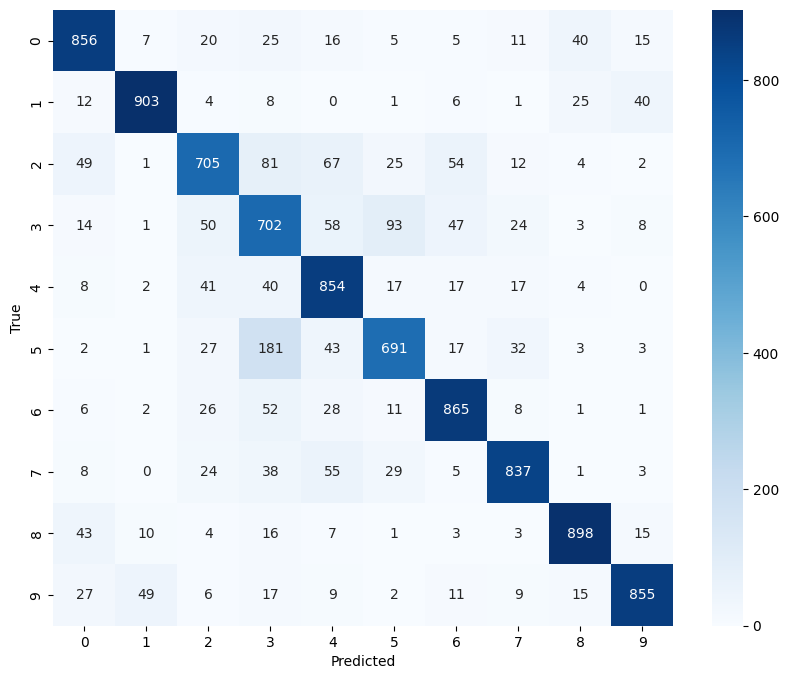

In [11]:
all_preds = []
true_labels = []
model.eval()  # Mode evaluasi
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())  # Simpan prediksi
        true_labels.extend(target.cpu().numpy())  # Simpan label sebenarnya

# Membuat confusion matrix
cm = confusion_matrix(true_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

- Diagonal utama menunjukkan jumlah prediksi yang benar, di mana label asli (True) sama dengan prediksi (Predicted). Angka-angka di diagonal ini cukup tinggi, yang menunjukkan bahwa model mampu melakukan prediksi yang benar untuk sebagian besar kelas.

- Kelas 1 dan 9 memiliki performa yang baik dengan angka prediksi benar masing-masing 903 dan 855, menunjukkan bahwa model cukup akurat dalam mengklasifikasikan gambar di kelas-kelas ini.

- Kelas 2 dan 3 terlihat memiliki lebih banyak kesalahan klasifikasi. Contohnya, untuk kelas 2, terdapat 49 gambar yang diklasifikasikan sebagai kelas 0, yang menunjukkan bahwa model mengalami kebingungan antara beberapa kelas.

- Kesalahan antar kelas terlihat pada beberapa titik di luar diagonal. Misalnya, ada cukup banyak kebingungan antara kelas 2 dan 0, serta antara kelas 3 dan 5, yang dapat disebabkan oleh kemiripan fitur visual pada gambar di kelas-kelas tersebut.

# Bagian 9: Laporan Klasifikasi
Tampilkan laporan precision, recall, F1-score untuk tiap kelas

In [12]:
print(classification_report(true_labels, all_preds))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.93      0.90      0.91      1000
           2       0.78      0.70      0.74      1000
           3       0.61      0.70      0.65      1000
           4       0.75      0.85      0.80      1000
           5       0.79      0.69      0.74      1000
           6       0.84      0.86      0.85      1000
           7       0.88      0.84      0.86      1000
           8       0.90      0.90      0.90      1000
           9       0.91      0.85      0.88      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



# Kesimpulan

Model **Convolutional Neural Network (CNN)** yang telah dilatih pada dataset **CIFAR-10** menunjukkan performa yang cukup baik. Berikut adalah beberapa poin penting dari hasil training dan testing dengan **PyTorch**:

### 1. Akurasi
- Model mencapai **akurasi 82%** pada dataset uji, yang berarti dari 10.000 gambar uji, sekitar 8.200 gambar berhasil diklasifikasikan dengan benar.
- Akurasi ini diperoleh setelah model dilatih selama 100 epoch menggunakan **PyTorch**, di mana fungsi loss dan optimasi (Adam optimizer) berjalan secara stabil hingga konvergen.

### 2. Evaluasi Performa Kelas
- **Kelas 1 (mobil), 8 (kapal), dan 9 (truk)** menunjukkan performa terbaik dengan **f1-score sekitar 0.88 - 0.91**, yang menandakan bahwa model sangat baik dalam mengenali gambar-gambar dari kelas-kelas ini.
- **Kelas 2 (burung) dan 3 (kucing)** memiliki performa yang lebih rendah, dengan **f1-score di bawah 0.70**. Ini berarti model kesulitan membedakan gambar dari kelas-kelas tersebut, kemungkinan karena kesamaan visual antara fitur objek dalam gambar-gambar burung dan pesawat, serta kucing dan anjing.

### 3. Waktu Training dengan PyTorch
- Proses training berlangsung selama **86 menit 25 detik**, menunjukkan bahwa model butuh waktu cukup lama untuk konvergen pada dataset CIFAR-10 yang memiliki kompleksitas tinggi.
- **PyTorch** memungkinkan efisiensi proses training berkat fitur automatic differentiation (autograd) dan optimasi yang disediakan. Meski demikian, waktu training masih cukup panjang mengingat kompleksitas gambar berwarna 32x32 piksel pada dataset ini.

### 4. Analisis Confusion Matrix
- Dari **confusion matrix** yang dihasilkan, terlihat beberapa kebingungan antar kelas, terutama antara:
  - **Kelas 2 (burung)** dan **kelas 0 (pesawat)**, di mana model salah mengklasifikasikan beberapa gambar burung sebagai pesawat.
  - **Kelas 3 (kucing)** dan **kelas 5 (anjing)**, yang mungkin disebabkan oleh kemiripan bentuk dan tekstur pada gambar kedua kelas ini.

  **PyTorch** menyediakan API yang mudah untuk mengumpulkan prediksi dan label, yang memungkinkan evaluasi hasil menggunakan **confusion matrix** secara langsung.

### Kesimpulan Akhir
Model ini menunjukkan performa yang cukup baik secara keseluruhan dengan akurasi **82%**. Namun, masih ada ruang untuk perbaikan, terutama pada kelas-kelas yang memiliki kemiripan visual seperti kelas burung dan kucing.